<div style="text-align: center;">
  <h2>Autor: William Nabhan Filho</h2>
</div>

## 1. Importando Bibliotecas e Módulos

In [1]:
import os, sys

sys.path.append(os.path.abspath('..'))

from src.clustering_utils import gerar_matriz_usuario, calcular_silhouette_scores, calcular_db_index, plot_elbow_method, \
plot_scores_index, kmeans, gerar_perfil_clusters, plot_proporcao_perfis_usuarios, salvar_clusters_csv, calc_dif_relativa, \
plot_clusters_pca_2d

import pandas as pd
import joblib

## 2. Preparação dos dados

### 2.1 Carregando os dados

In [2]:
data = pd.read_parquet('../data/processed/data.parquet')

### 2.2 Normalizando os dados

In [3]:
#Obtendo matrizes de contagem e proporção de departamentos comprados por usuário
matriz_usuario, matriz_usuario_prop = gerar_matriz_usuario(data)

Na matriz_usuario_prop, os valores em cada linha são transformados para representar proporções (frações do total de compras do usuário), colocando-os automaticamente em uma escala: [0, 1]

## 3. Escolha do Algoritmo de Clusterização

Para escolha do algoritmo de clusterização (**K-means** ou **Gaussian Mixture Model**), decidiu-se avaliar as métricas **Silhouette Score** e **Davies-Bouldin Index** para o conjunto dados em um intervalo de 2 a 10 clusters (selecionado para analisar diferentes granularidades de agrupamento).
Essa decisão visa avaliar os clusters dos diferentes modelos quanto à sua coesão (quão compactos são) e separação (quão distantes estão uns dos outros).
- **Silhouette Score**: Valores dentro do intervalo [1, -1]. Mede a coesão (distância dentro do cluster) e a separação (distância para outros clusters) por ponto. Valores próximos de 1 indicam bons clusters, enquanto valores negativos indicam erros de agrupamento.
- **Davies-Bouldin Index**: Valores dentro do intervalo [0, infinito). Mede a qualidade dos clusters com base na razão entre a dispersão dentro dos clusters e a separação entre eles. Valores menores indicam melhor qualidade, com 0 sendo o ideal.

In [4]:
#Obtendo os valores de Silhouette Score e Davies-Bouldin Index para o intervalo de 2 a 10 clusters
silhouette_scores_gmm, silhouette_scores_kmeans, df_silhouette_scores = calcular_silhouette_scores(matriz_usuario_prop)
db_gmm, db_kmeans, df_db_index = calcular_db_index(matriz_usuario_prop)

In [5]:
df_db_index

,n_clusters,index_gmm,index_kmeans
0,2,5.436334,1.503857
1,3,7.979931,1.773948
2,4,7.291781,1.745575
3,5,6.631993,1.665073
4,6,7.679282,1.655823
5,7,7.328625,1.793780
6,8,6.781721,1.790378
7,9,6.911821,1.730656
8,10,6.569167,1.730602


In [6]:
df_silhouette_scores

,n_clusters,score_gmm,score_kmeans
0,2,0.016141,0.227361
1,3,-0.054470,0.199587
2,4,-0.068007,0.153601
3,5,-0.065856,0.160546
4,6,-0.074825,0.158673
5,7,-0.099506,0.122939
6,8,-0.109265,0.127244
7,9,-0.083282,0.128976
8,10,-0.086670,0.121299


Com base nas métricas avaliadas, o **K-means** apresentou **Silhouette Scores** consistentemente **superiores** para **todos** os números de clusters testados, indicando **maior coesão e melhor separação** entre os grupos. Além disso, obteve **índices de Davies-Bouldin** mais **baixos**, reforçando a **qualidade dos agrupamentos em termos de dispersão interna e distinção entre clusters**. Por outro lado, o **GMM** teve desempenho insatisfatório, com Silhouette Scores **negativos** e índices de Davies-Bouldin **elevados**, sugerindo que os dados não se ajustam bem à suposição de distribuições gaussianas.   
Assim, o **K-means** se mostrou o algoritmo **mais apropriado** para a segmentação dos clientes neste conjunto de dados.

## 4. Escolha do Número de Clusters

Para identificar o ponto de melhor equilíbrio entre compactação dos clusters e complexidade do modelo foi utilizado o **Elbow Method** (Método do Cotovelo).

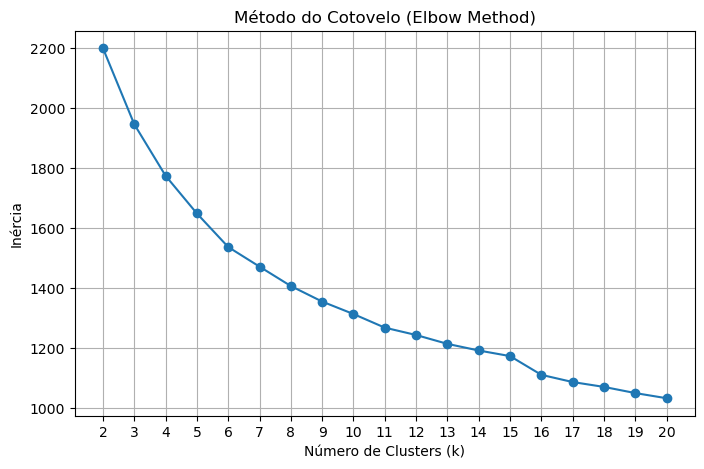

Diferença Absoluta e Relativa da Queda de Inércia entre número de clusters:
Ki → Kj : (diff_absoluta; diff_relativa)
2 → 3: (-253.4730; -0.1152)
3 → 4: (-171.7796; -0.0883)
4 → 5: (-125.5974; -0.0708)
5 → 6: (-111.8686; -0.0678)
6 → 7: (-65.3889; -0.0425)
7 → 8: (-64.6246; -0.0439)
8 → 9: (-51.8593; -0.0369)
9 → 10: (-41.5477; -0.0307)
10 → 11: (-45.3670; -0.0345)
11 → 12: (-24.5257; -0.0193)
12 → 13: (-29.5378; -0.0237)
13 → 14: (-22.1107; -0.0182)
14 → 15: (-18.6472; -0.0156)
15 → 16: (-62.4829; -0.0532)
16 → 17: (-24.0407; -0.0216)
17 → 18: (-16.2100; -0.0149)
18 → 19: (-20.5540; -0.0192)
19 → 20: (-17.1564; -0.0163)


In [7]:
#Plotando o gráfico de cotovelo para o intervalo de 2 a 20 clustetrs
plot_elbow_method(matriz_usuario_prop, k_max=20)

Analisando o gráfico e os arrays de diferença absoluta e relativa entre os números subsequentes de clusters, percebe-se que a partir de **4 clusters** a inércia deixa de decrescer com a mesma intensidade. Esse comportamento se acentua ainda mais após **6 clusters**, indicando que o acréscimo de novos grupos além desse ponto representa **alto custo computacional** com pouca melhoria na qualidade do clustering.   
Para continuar com a escolha do número de clusters mais apropriado, analisaremos novamente o Silhouette Score e o Davies-Bouldin Index, que avalia a qualidade de coesão e separação entre os clusters.

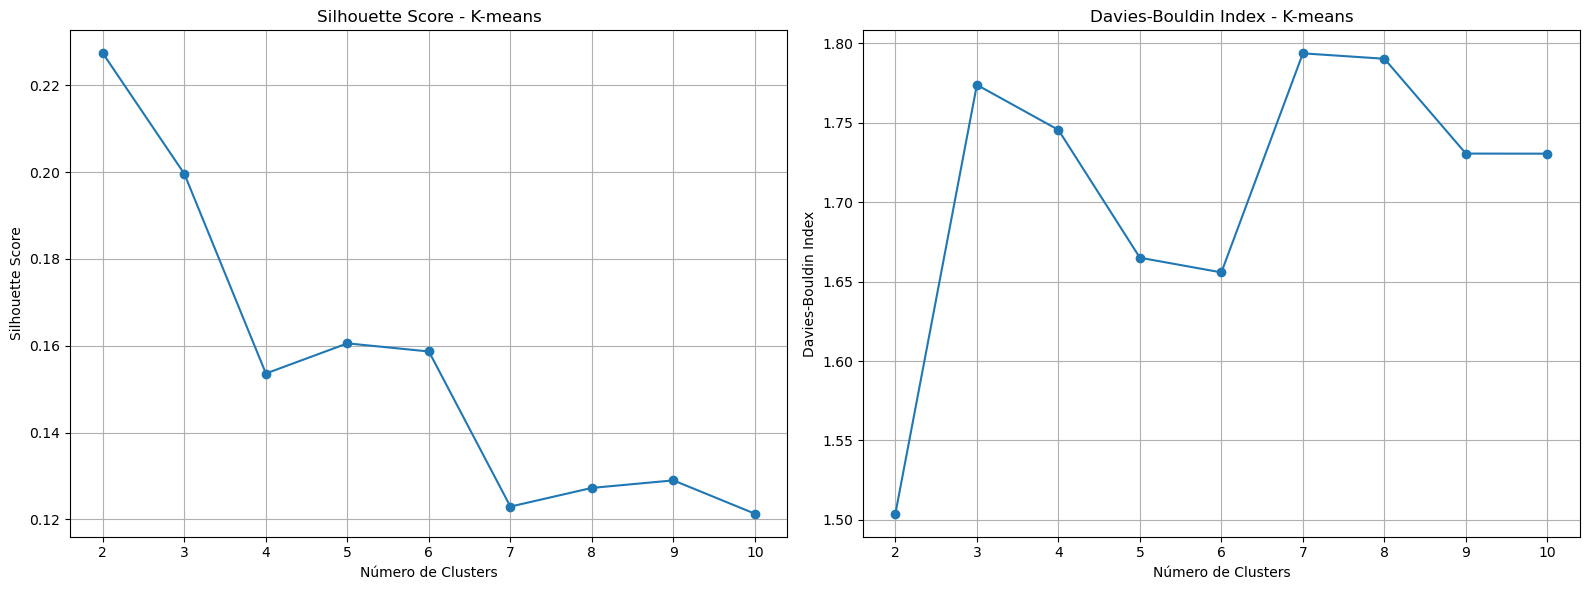

In [8]:
#Plotando o gráfico do silhouette score e Davies-Bouldin Index para um intervalo de 2 a 10 clusters
plot_scores_index(range(2, 11), silhouette_scores_kmeans, db_kmeans, modelo_nome='K-means')

Ao analisar o Silhouette Score e Davies-Bouldin Index, observa-se que um número de clusters maior que 6 não apenas reduz a separação entre grupos (decréscimo do valor de Silhouette Score e aumento do valor de Davies-Bouldin Index), como também impacta negativamente a aplicabilidade prática de estratégias de marketing. Perfis menos distintos dificultam ações personalizadas, diluindo a eficácia de campanhas segmentadas.   
Considerando o contexto de segmentação de clientes de **supermercado**, onde se busca ações de marketing **mais diretas e operacionais**, a criação de muitos clusters tende a gerar perfis menos distintos e pouco aplicáveis na prática, logo, optou-se por um **número de clusters igual a 3**.

## 5. Clusterização

In [9]:
#Clusterizando cada instância ('user_id') na matriz_usuario_prop_clusterizada
matriz_usuario_prop_clusterizada, modelo_kmeans = kmeans(matriz_usuario_prop, n_clusters=3)

In [10]:
# Salvando o modelo para agrupar novos dados no futuro
joblib.dump(modelo_kmeans, '../results/modelo_kmeans_3_clusters.pkl')

['../results/modelo_kmeans_3_clusters.pkl']

In [11]:
#Gerando um csv com user_id e cluster para gerar regras de associação para cada cluster
salvar_clusters_csv(matriz_usuario_prop_clusterizada, '../results/user_id_clusters.csv')

## 6. Análise de Perfil dos Grupos (Clusters)

O Silhouette score de aproximadamente 0,20 e o índice de Davies-Bouldin de aproximadamente 1,77 indicam clusters com alguma sobreposição, o que é esperado em dados de hábitos de compra devido à sua natureza heterogênea. Para validar o uso de 3 clusters foi avaliada a interpretabilidade dos perfis, e, para isso, foram analisados os centróides dos 3 clusters, que representam a média das proporções de compra por departamento entre os usuários de cada grupo, definindo o perfil de consumo de cada grupo. 

In [12]:
#Gerando a média da proporção de cada departamento por cluster para criar os perfis dos grupos de usuários
perfil_clusters  = gerar_perfil_clusters(modelo_kmeans, matriz_usuario_prop_clusterizada)

In [13]:
# Visualizando a média da proporção de cada departamento por cluster
perfil_clusters

,0,1,2
alcohol,0.007226,0.001836,0.027901
babies,0.013055,0.005301,0.005489
bakery,0.043129,0.026163,0.026923
beverages,0.073024,0.051947,0.280881
breakfast,0.026633,0.013834,0.024962
bulk,0.000749,0.001230,0.000793
canned goods,0.037072,0.032551,0.016853
dairy eggs,0.193316,0.132189,0.093054
deli,0.035160,0.028180,0.022687
dry goods pasta,0.031441,0.021964,0.013593


In [14]:
# Visualizando a diferença relativa para cada categoria entre clusters
perfil_clusters.apply(calc_dif_relativa, axis=1)

,0,1,2
alcohol,-0.513981,-0.895446,5.157249
babies,1.419702,-0.428266,-0.401907
bakery,0.624875,-0.253044,-0.222910
beverages,-0.561188,-0.706437,3.495133
breakfast,0.372968,-0.463755,0.233717
bulk,-0.259223,0.595157,-0.198785
canned goods,0.500786,0.207263,-0.515883
dairy eggs,0.716521,-0.076799,-0.428251
deli,0.382408,-0.025694,-0.283641
dry goods pasta,0.768484,-0.024566,-0.490941


In [15]:
#Ordenando de forma decrescente para melhor interpretação do perfil do cluster 0
perfil_clusters.sort_values(by=0, ascending=False).iloc[:,0]

produce            0.198969
dairy eggs         0.193316
frozen             0.091607
snacks             0.086790
beverages          0.073024
pantry             0.070566
bakery             0.043129
canned goods       0.037072
deli               0.035160
dry goods pasta    0.031441
household          0.029467
breakfast          0.026633
meat seafood       0.025466
personal care      0.018368
babies             0.013055
international      0.009432
alcohol            0.007226
pets               0.004375
missing            0.002681
other              0.001470
bulk               0.000749
Name: 0, dtype: float64

**Características principais**:  
- Alta proporção de produce (0.198969) e dairy eggs (0.193316), indicando preferência por laticínios e produtos frescos.
- Proporções moderadas em frozen (0.091607), snacks (0.08679), beverages (0.073024) e pantry (0.070566).
- Baixa proporção em bulk (0.000749), other (0.001470) e missing (0.002681), mostrando pouco interesse em compras em grandes quantidades ou itens diversos.
- Elevada proporção de babies (0.013055) em comparação com o cluster 1 e 2 (0.005301 e 0.005489 respectivamente).

In [16]:
#Ordenando de forma decrescente para melhor interpretação do perfil do cluster 1
perfil_clusters.sort_values(by=1, ascending=False).iloc[:,1]

produce            0.474730
dairy eggs         0.132189
snacks             0.055066
pantry             0.052909
beverages          0.051947
frozen             0.046779
canned goods       0.032551
deli               0.028180
bakery             0.026163
meat seafood       0.023010
dry goods pasta    0.021964
breakfast          0.013834
household          0.012208
personal care      0.008494
international      0.007553
babies             0.005301
missing            0.002334
alcohol            0.001836
bulk               0.001230
pets               0.000885
other              0.000837
Name: 1, dtype: float64

**Características principais**:  
- Altíssima proporção em produce (0.47473) e alta proporção em dairy eggs (0.132189), indicando forte preferência por produtos frescos e laticínios.
- Proporções moderadas em snacks (0.05506), pantry (0.052909), beverages (0.051947) e frozen (0.046779).
- Baixa proporção em alcohol (0.001836), pets (0.000885) e other (0.000837), indicando pouco interesse em bebidas alcoólicas, itens para pets e produtos diversos.

In [17]:
#Ordenando de forma decrescente para melhor interpretação do perfil do cluster 2
perfil_clusters.sort_values(by=2, ascending=False).iloc[:,2]

beverages          0.280881
snacks             0.175841
dairy eggs         0.093054
produce            0.080304
household          0.066033
frozen             0.058320
pantry             0.047186
personal care      0.032833
alcohol            0.027901
bakery             0.026923
breakfast          0.024962
deli               0.022687
canned goods       0.016853
dry goods pasta    0.013593
meat seafood       0.010623
babies             0.005489
pets               0.005485
international      0.005180
missing            0.002614
other              0.002446
bulk               0.000793
Name: 2, dtype: float64

**Características principais**:  
- Alta proporção em beverages (0.280881) e snacks (0.175841), mostrando uma preferência dominante por bebidas e lanches.
- Proporções moderadas em diary eggs (0.093054), produce (0.080304) e household (0.066033).
- Baixa proporção em bulk (0.000793), babies (0.005489) e pets (0.005485), indicando pouco interesse em compras em grandes quantidades, produtos internacionais e itens para bebês.
- Elevada proporção de alcohol (0.027901) em comparação com o cluster 0 e 1 (0.007226 e 0.001836 respectivamente).

### **Resumo dos Perfis**
**Cluster 0:** Consumidores variados, focados em laticínios e produtos frescos, com compras planejadas (famílias).   
**Cluster 1:** Consumidores variados, focados em saúde, com ênfase em produtos frescos e laticínios (indivíduos preocupados com nutrição, alguns possivelmente vegetarianos, atletas e fitness).  
**Cluster 2:** Consumidores que buscam praticidade, priorizando lanches e bebidas (jovens ou solteiros com estilo de vida casual e ativa).

### **Conclusão**
Os centróides dos clusters revelam perfis claramente distintos, oferecendo insights acionáveis para estratégias de marketing descritas adiante. Logo, a adoção de 3 clusters equilibra qualidade de segmentação, interpretabilidade dos perfis e utilidade prática.

## 7. Proporção dos Grupos de Usuários

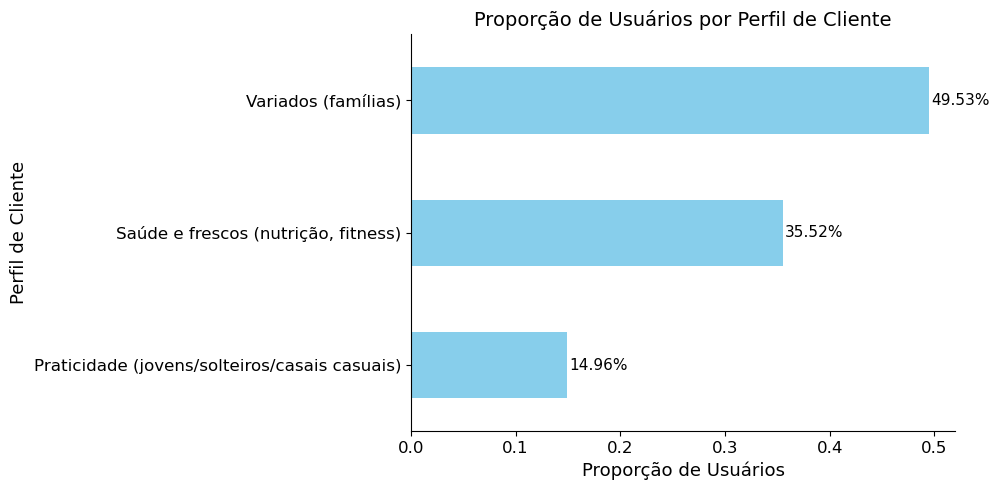

In [18]:
# Mapeando os perfis para cada cluster
mapa_perfis = {
    0: 'Variados (famílias)',
    1: 'Saúde e frescos (nutrição, fitness)',
    2: 'Praticidade (jovens/solteiros/casais casuais)'
}

plot_proporcao_perfis_usuarios(matriz_usuario_prop_clusterizada, mapa_perfis, figsize=(10, 5))


## 8. Visualização 2D dos clusters por PCA

Para viabilizar a visualização da separação entre os grupos de clientes em um espaço bidimensional, aplicou-se a Análise de Componentes Principais (PCA). Para isso, os dados de 'matriz_usuario_prop_clusterizada' foram padronizados utilizando o StandardScaler, o que garantiu média zero e variância unitária para todas as variáveis, assegurando que a projeção do PCA não fosse enviesada por atributos com maior variabilidade.

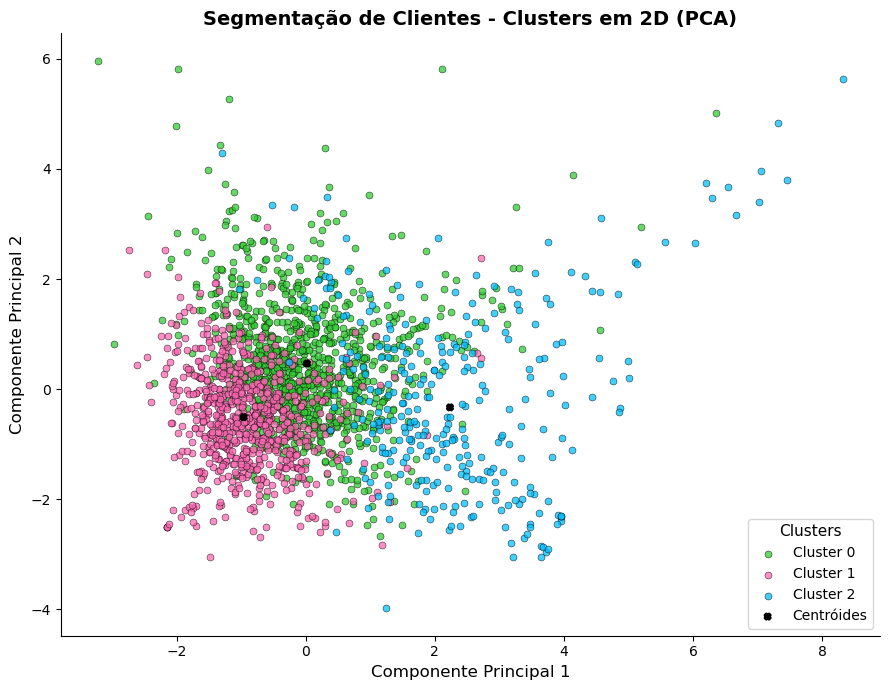

In [20]:
plot_clusters_pca_2d(matriz_usuario_prop_clusterizada, caminho_salvar='../results/plot_2d_clusters_pca.png')

A visualização acima, embora uma simplificação 2D dos dados de alta dimensionalidade, corrobora com os valores de Silhouette Score de Davies-Bouldin obtidos, indicando **separação razoável** entre clusters.   
Além disso, percebe-se uma maior dispersão do Cluster 0, o que é coerente com seu perfil de consumidores variados e famílias, que não apresentam um padrão específico de compra. Essa diversidade de comportamento resulta em uma **maior dispersão** dos pontos no espaço PCA, refletindo escolhas **mais heterogêneas**.   
Por outro lado, a maior coesão visual dos Cluster 1 indica um grupo de consumidores com hábitos de compra **mais consistentes**, fortemente alinhados ao perfil com foco em saúde. Esse padrão é reforçado pela **alta concentração** de compras no departamento ‘produce’ (frutas, legumes e verduras), que corresponde a cerca de 50% do volume de compras desses consumidores.   
Já o Cluster 2 apresenta uma **maior distinção espacial** em relação aos demais, especialmente nos extremos da projeção, sugerindo um perfil mais específico. Essa diferenciação é justificada pela predominância combinada de compras nos departamentos de ‘beverages’ e ‘snacks’, em contraste com os demais grupos, que apresentam proporções significativamente menores de compras nesses departamentos.

## Limitações do Modelo Utilizado

A comparação de métodos de clusterização levou à escolha do K-means, que identificou padrões relevantes e gerou perfis de clientes claros e distintos, proporcionando insights valiosos para estratégias de marketing. No entanto, o Silhouette Score de 0,20 e o índice Davies-Bouldin de 1,77 indicam uma **sobreposição moderada** entre os clusters, sugerindo que os dados não apresentam uma estrutura de clusters **bem definida**.  
Como uma extensão desse estudo,  recomenda-se explorar algoritmos como **HDBSCAN** ou **Spectral Clustering**, além de reavaliar as variáveis selecionadas e aplicar técnicas de redução de dimensionalidade não linear para aprimorar a separação entre os grupos.

#### **No próximo notebook, aprofundaremos a análise identificando combinações frequentes de departamentos de produtos por meio do algoritmo Apriori, buscando revelar padrões de compra conjunta que podem impulsionar vendas cruzadas e aprimorar a experiência digital para cada grupo de usuários.**